In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import networkx as nx 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
df = pd.read_csv('/Users/anmar/Downloads\heart_attack_analysis.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [15]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.62376

In [19]:
#Split to training and testing data
df_train, df_test = train_test_split(df, test_size=0.2)

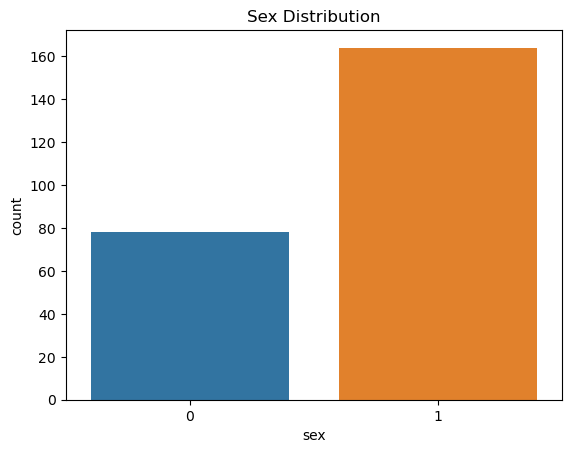

In [21]:
sns.countplot(x='sex', data=df_train)
plt.title("Sex Distribution")
plt.show()

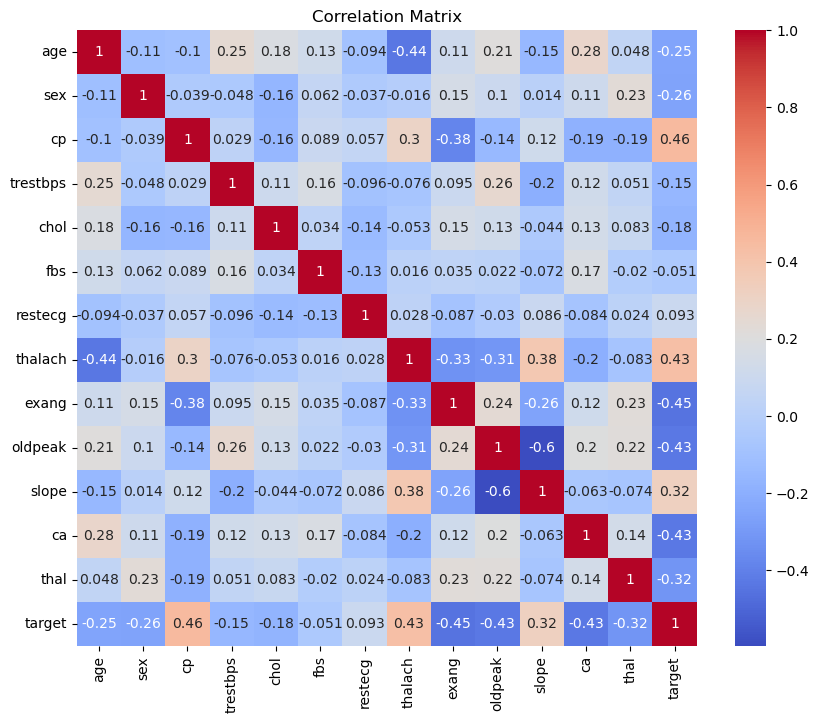

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [23]:
features = df.select_dtypes(include=['int64', 'float64']).columns
features

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [24]:
#Identify outliers by using IQR method.
Q1 = df_train[features].quantile(0.25)
Q3 = df_train[features].quantile(0.75)
IQR = Q3 - Q1

#Boolean DataFrame indicating whether a value is an outlier
outliers = (df_train[features] < (Q1 - 1.5 * IQR)) | (df_train[features] > (Q3 + 1.5 * IQR))

print(outliers.sum())
df_train_outliers = df_train[outliers.any(axis=1)]
print("Number of rows with outliers in any feature:", len(df_train_outliers))

age          0
sex          0
cp           0
trestbps     6
chol         4
fbs         39
restecg      0
thalach      1
exang        0
oldpeak      3
slope        0
ca          22
thal         2
target       0
dtype: int64
Number of rows with outliers in any feature: 63


In [44]:
def outlier_analysis(train_df: pd.DataFrame, test_df: pd.DataFrame, feature: str):
    # Scatterplot of the 50 highest values in the train-set and test-set
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plotting the top 50 values in train and test data
    sns.scatterplot(x=train_df[feature].sort_values(ascending=False)[:50], 
                    y=[10] * len(train_df[:50]), label="Train data", color="blue", ax=axes[0])
    sns.scatterplot(x=test_df[feature].sort_values(ascending=False)[:50], 
                    y=[20] * len(test_df[:50]), label="Test data", color="red", ax=axes[0])
    axes[0].set_title(f"Fig 1: Scatter Plot of {feature} comparing train and test data", fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # CDF plot of both datasets
    sns.ecdfplot(x=train_df[feature], color="blue", label="Train data", ax=axes[1])
    sns.ecdfplot(x=test_df[feature], color="red", label="Test data", ax=axes[1])
    axes[1].set_title(f"Fig 2: CDF of {feature}", fontsize=10)
    axes[1].grid(True, linestyle="--", alpha=0.5)
    
    # Calculate the outlier threshold
    outlier_threshold = train_df[feature].quantile(0.99)
    axes[1].axvspan(outlier_threshold, train_df[feature].max(), color="red", alpha=0.1, label="Potential Outliers")
    axes[1].legend()
    
    # Identify outliers in the train and test datasets
    train_outliers = train_df[train_df[feature] > outlier_threshold]
    test_outliers = test_df[test_df[feature] > outlier_threshold]
    
    # Print or return the outliers
    print(f"Outliers in train data for {feature} (values > {outlier_threshold}):")
    print(train_outliers[[feature]])
    
    print(f"\nOutliers in test data for {feature} (values > {outlier_threshold}):")
    print(test_outliers[[feature]])
    
    # Scatterplot of all datapoints in trainset with respect to the target variable "output"
    if "output" in train_df.columns:
        sns.scatterplot(data=train_df, x=feature, y="output", ax=axes[2])
        axes[2].set_title(f"Fig 3: Scatterplot of {feature} with respect to Output", fontsize=10)
        axes[2].grid(True, linestyle="--", alpha=0.5)
    else:
        axes[2].text(0.5, 0.5, 'Output column not found in train_df', horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)
        axes[2].set_title("Fig 3: Missing Output Column", fontsize=10)
    
    plt.tight_layout()
    plt.show()

Outliers in train data for trestbps (values > 179.18):
     trestbps
203       180
266       180
223       200

Outliers in test data for trestbps (values > 179.18):
     trestbps
248       192
110       180


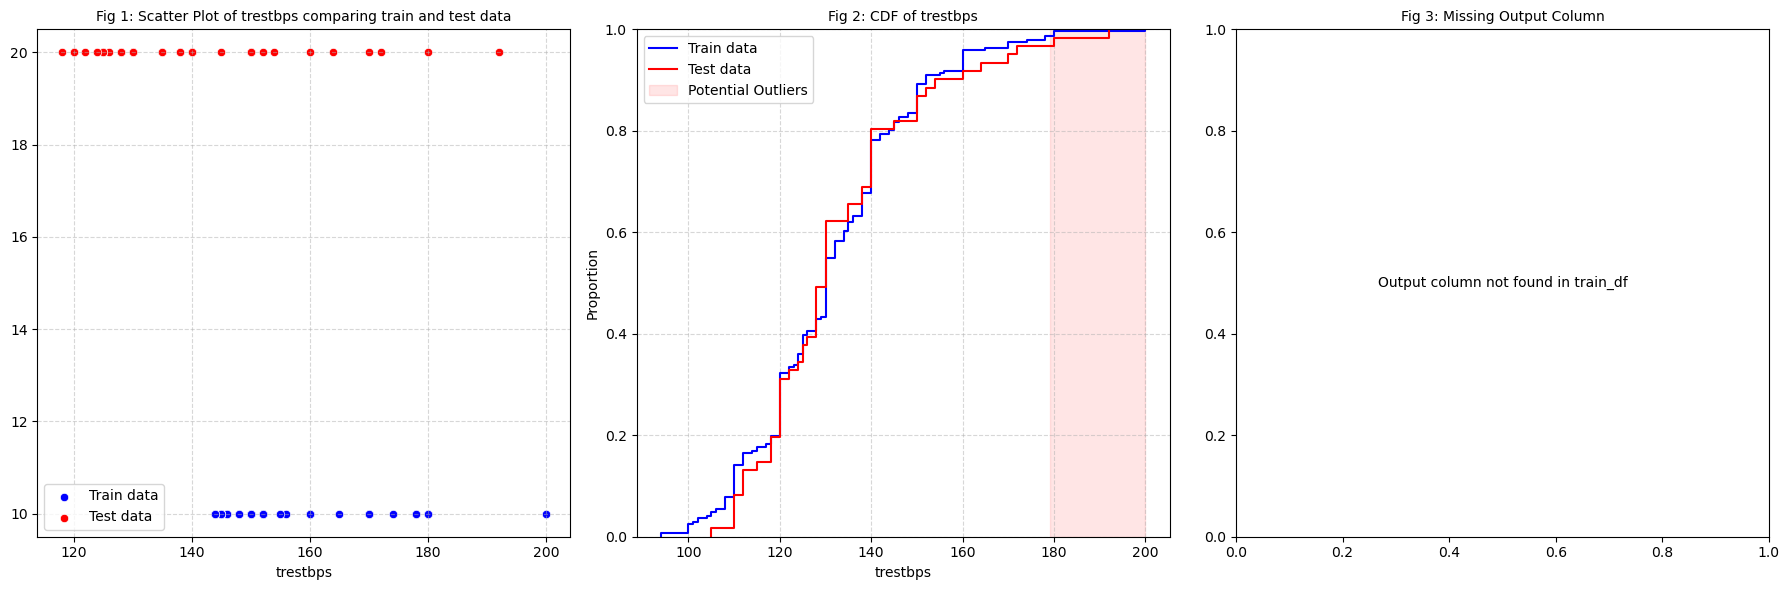

In [45]:
outlier_analysis(df_train, df_test, 'trestbps')

Outliers in train data for chol (values > 401.6700000000001):
     chol
246   409
220   407
28    417

Outliers in test data for chol (values > 401.6700000000001):
    chol
85   564


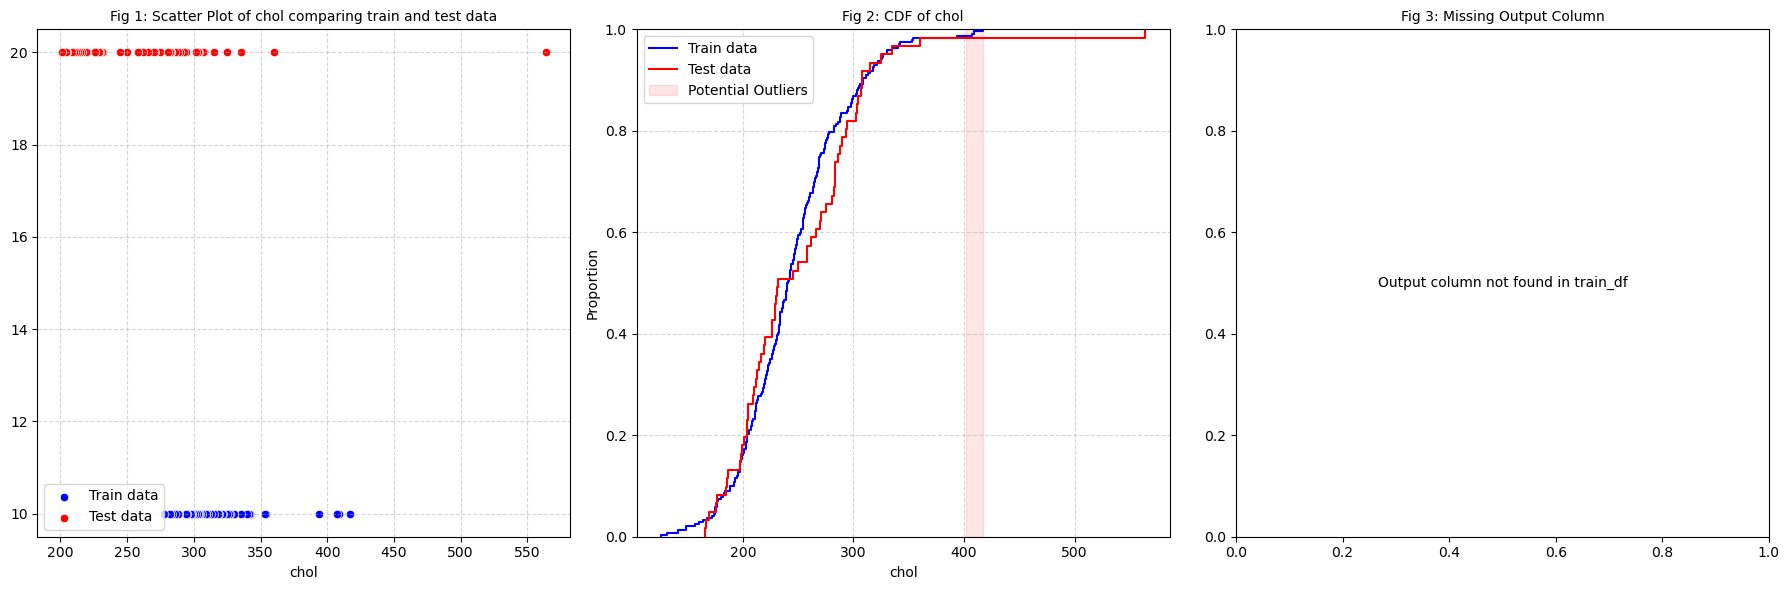

In [46]:
outlier_analysis(df_train, df_test, 'chol')

Outliers in train data for fbs (values > 1.0):
Empty DataFrame
Columns: [fbs]
Index: []

Outliers in test data for fbs (values > 1.0):
Empty DataFrame
Columns: [fbs]
Index: []


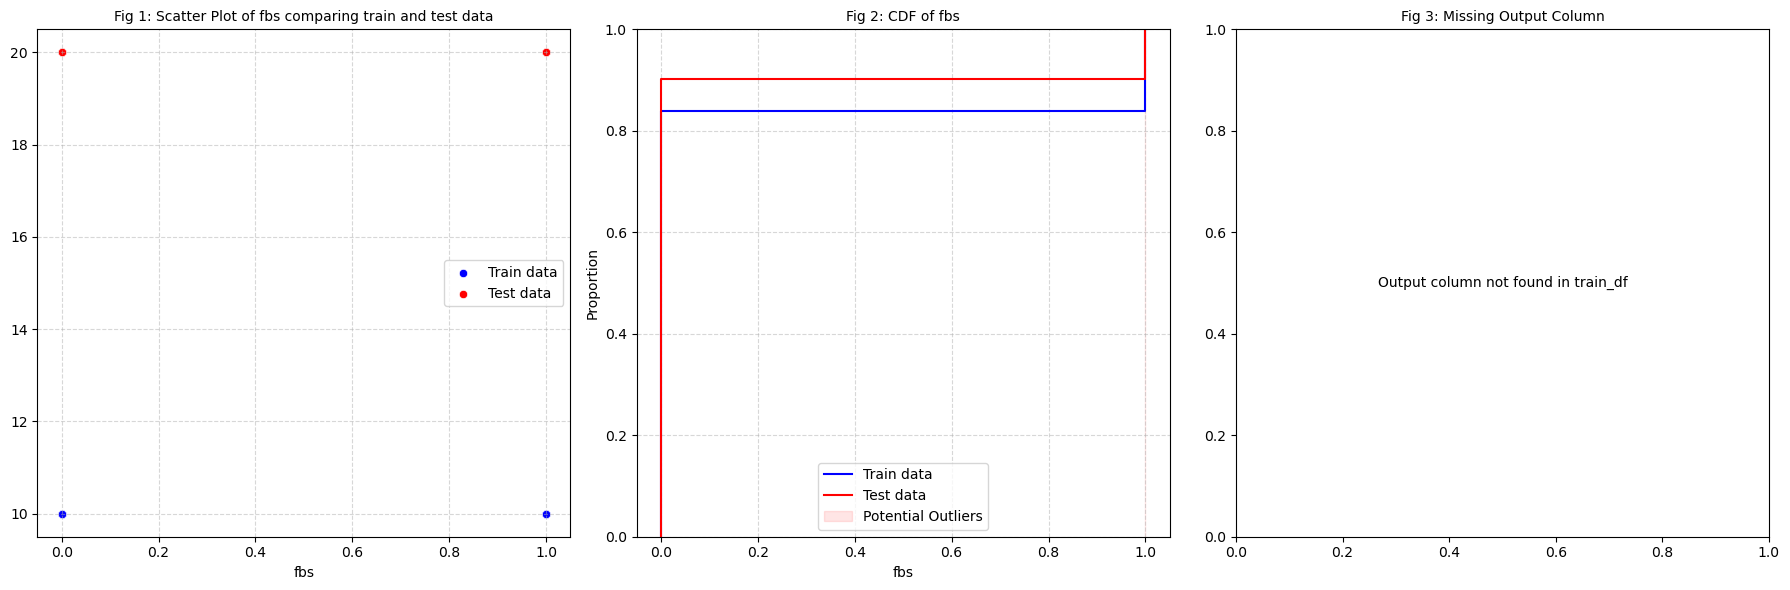

In [47]:
outlier_analysis(df_train, df_test, 'fbs')

Outliers in train data for restecg (values > 1.5900000000000034):
     restecg
266        2
291        2
144        2

Outliers in test data for restecg (values > 1.5900000000000034):
     restecg
289        2


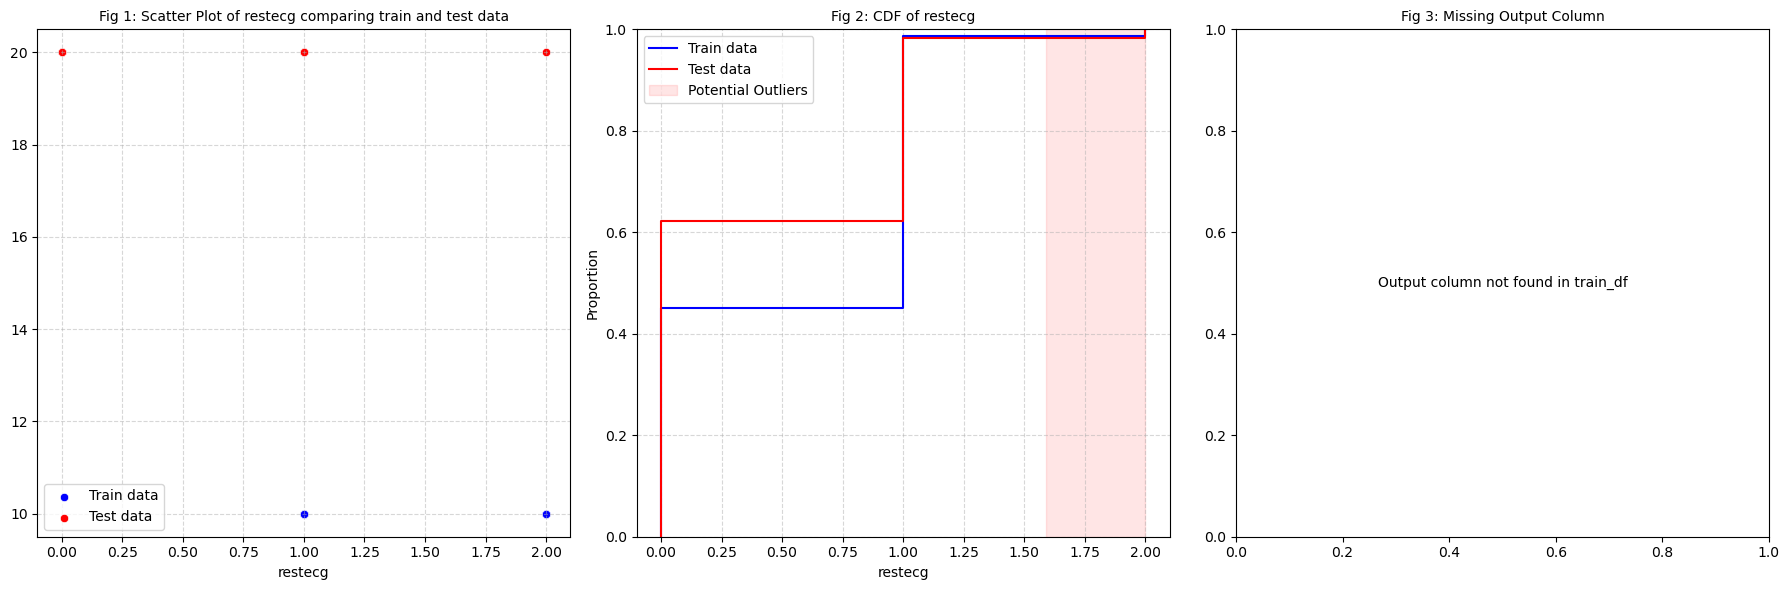

In [48]:
outlier_analysis(df_train, df_test, 'restecg')

Outliers in train data for thalach (values > 187.59):
     thalach
103      194
72       202
32       188

Outliers in test data for thalach (values > 187.59):
     thalach
62       190
125      192
248      195


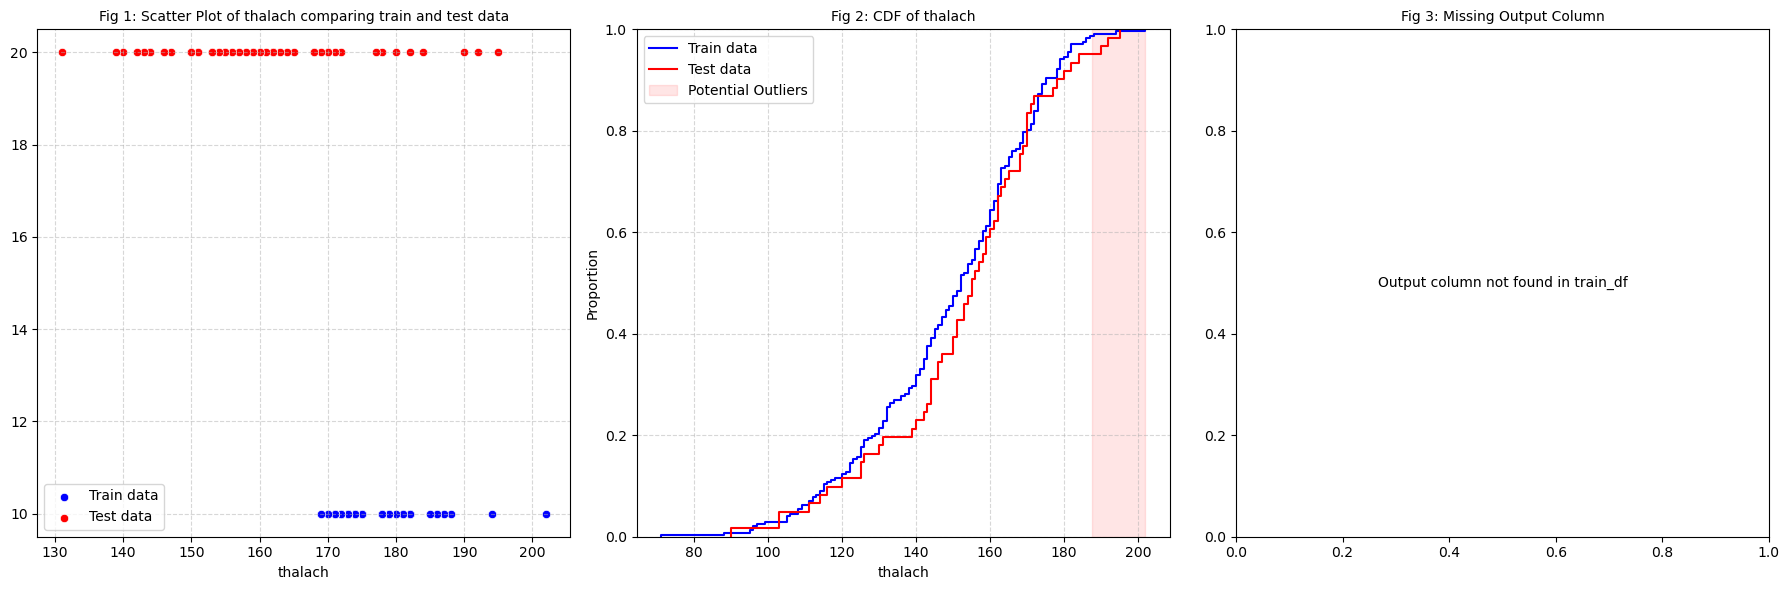

In [49]:
outlier_analysis(df_train, df_test, 'thalach')

Outliers in train data for exang (values > 1.0):
Empty DataFrame
Columns: [exang]
Index: []

Outliers in test data for exang (values > 1.0):
Empty DataFrame
Columns: [exang]
Index: []


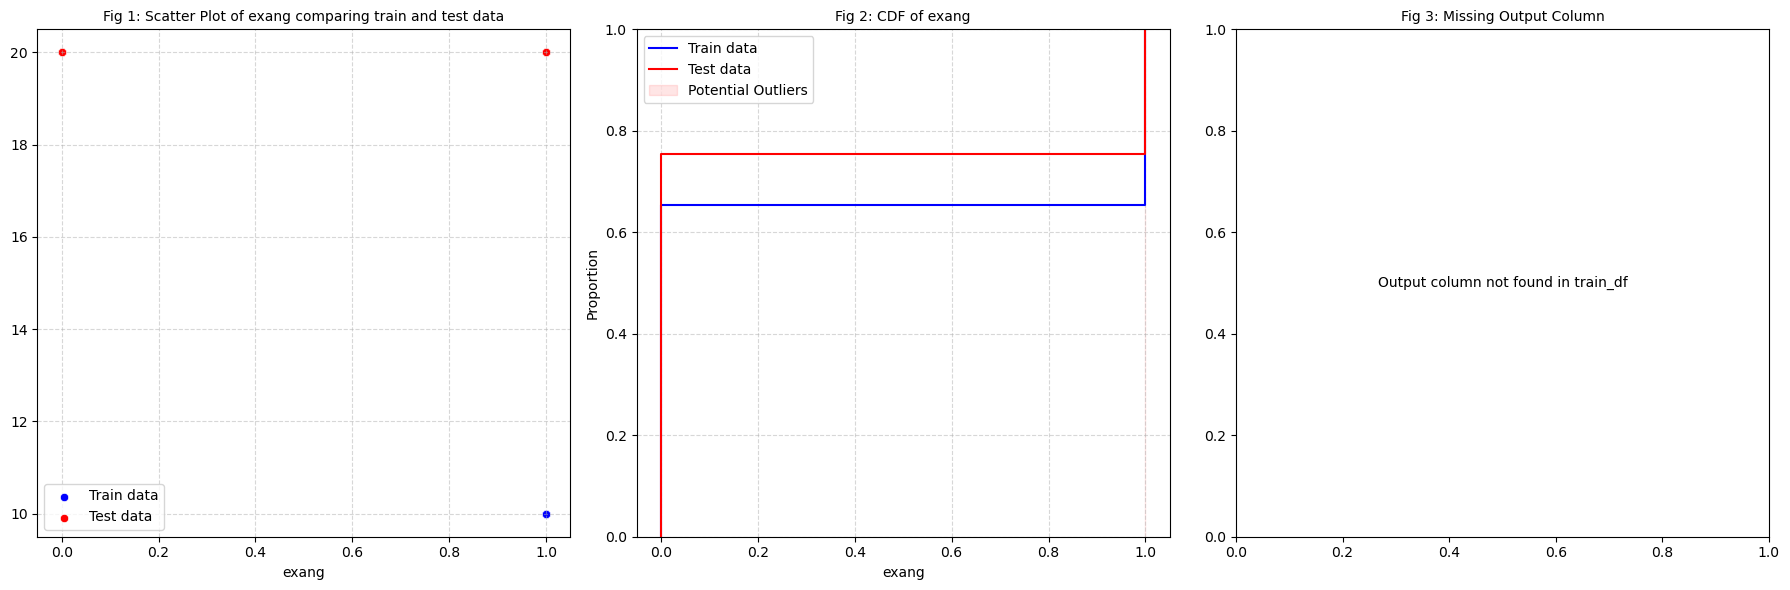

In [50]:
outlier_analysis(df_train, df_test, 'exang')

Outliers in train data for oldpeak (values > 4.318000000000001):
     oldpeak
291      4.4
204      6.2
221      5.6

Outliers in test data for oldpeak (values > 4.318000000000001):
Empty DataFrame
Columns: [oldpeak]
Index: []


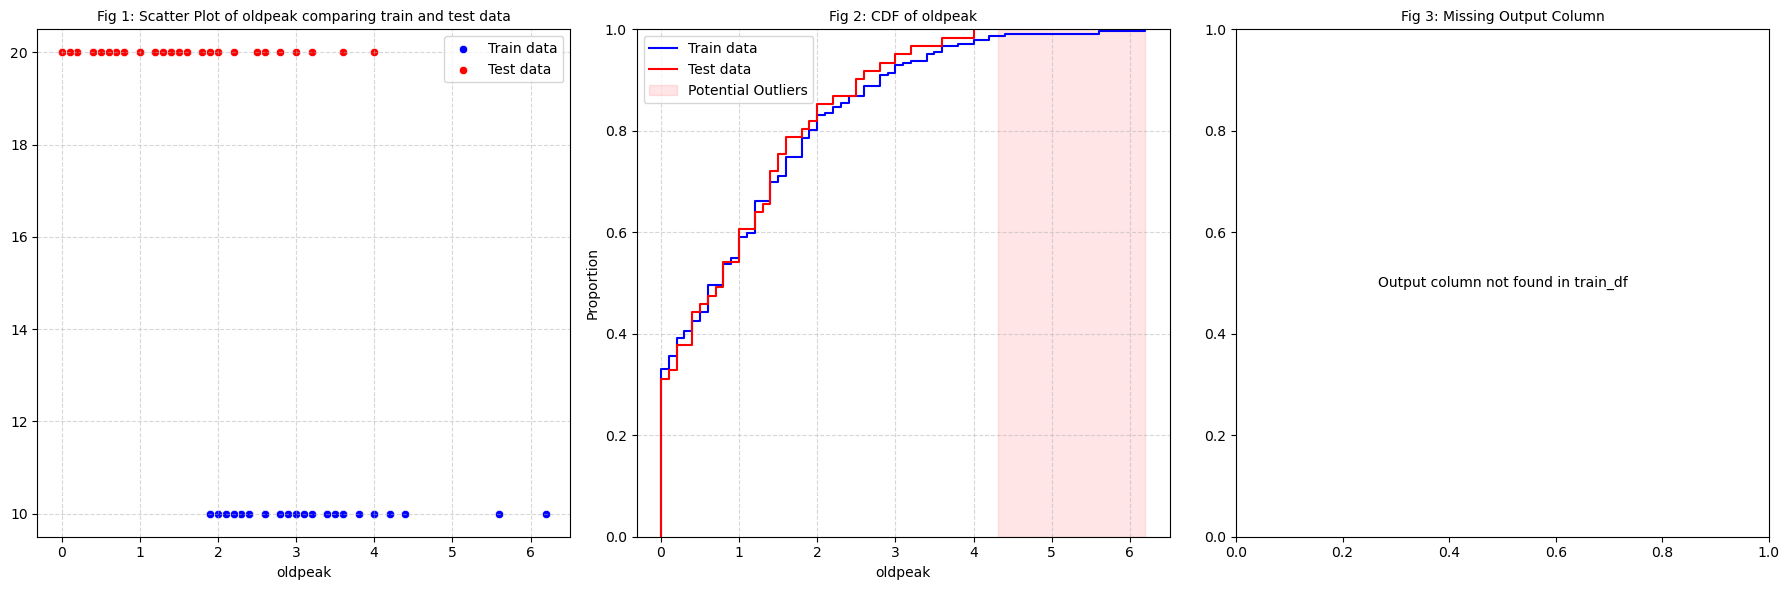

In [51]:
outlier_analysis(df_train, df_test, 'oldpeak')

Outliers in train data for ca (values > 4.0):
Empty DataFrame
Columns: [ca]
Index: []

Outliers in test data for ca (values > 4.0):
Empty DataFrame
Columns: [ca]
Index: []


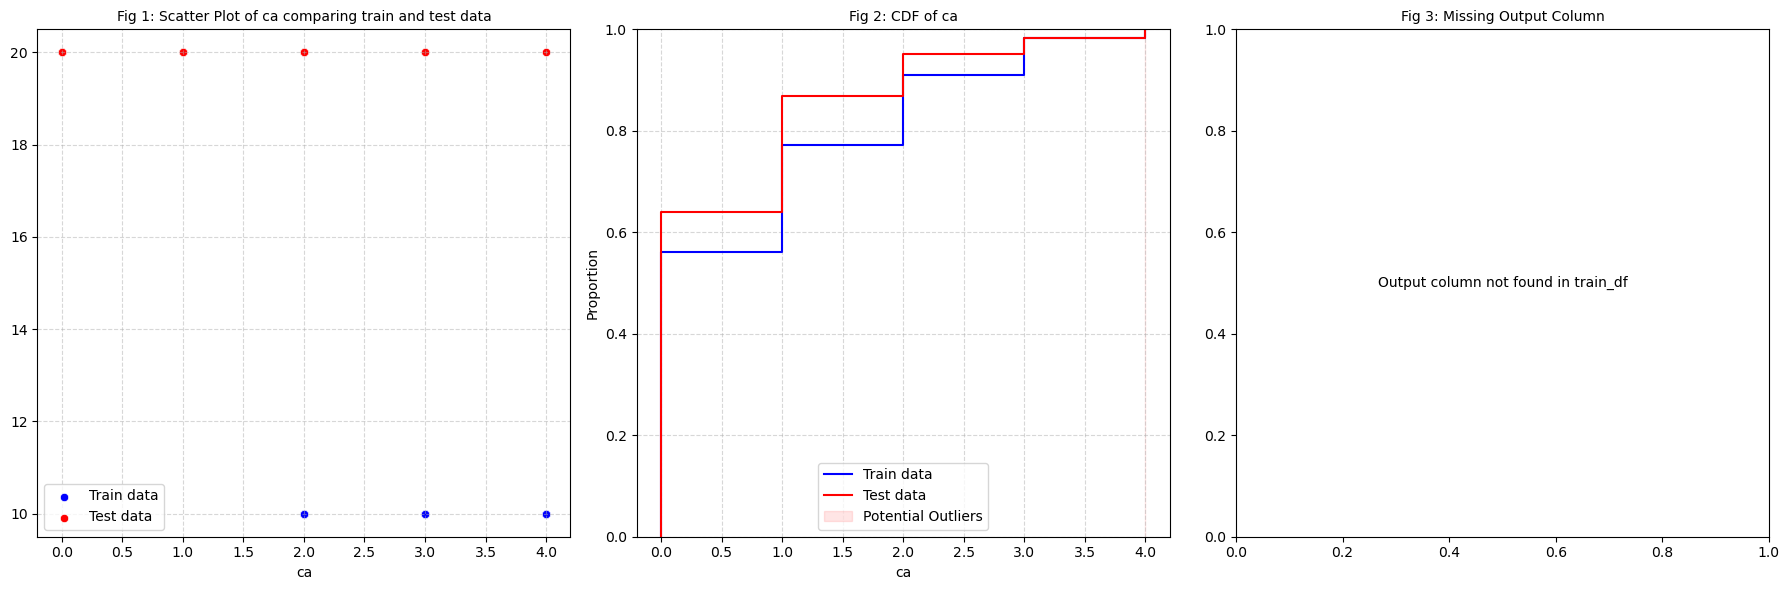

In [52]:
outlier_analysis(df_train, df_test, 'ca')

Outliers in train data for thal (values > 3.0):
Empty DataFrame
Columns: [thal]
Index: []

Outliers in test data for thal (values > 3.0):
Empty DataFrame
Columns: [thal]
Index: []


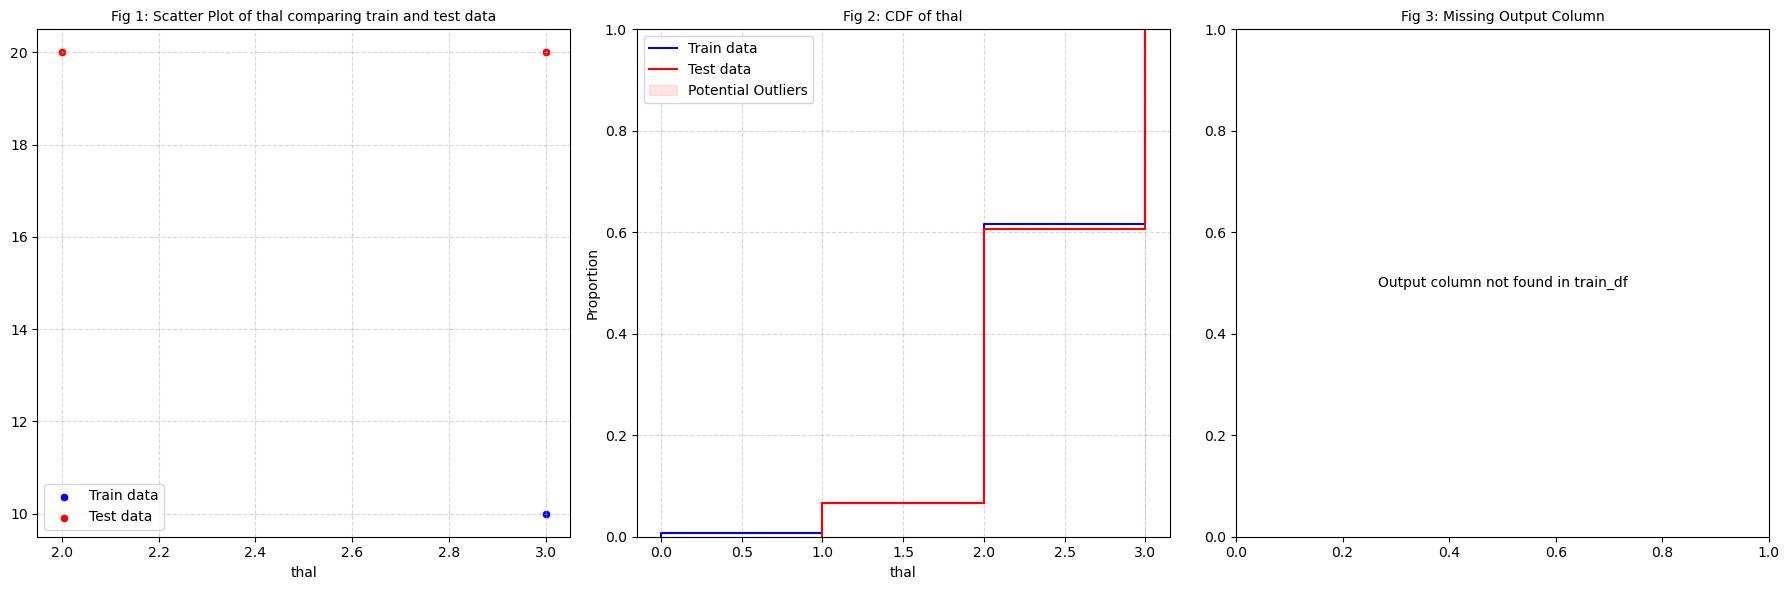

In [53]:
outlier_analysis(df_train, df_test, 'thal')

In [55]:
df_train = df_train[df_train['trestbps'] <= 179.18]
df_train = df_train[df_train['chol'] <= 401.67]
df_train = df_train[df_train['restecg'] <= 1.59]
df_train = df_train[df_train['thalach'] <= 187.59]
df_train = df_train[df_train['oldpeak'] <= 4.318]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 161 to 243
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       229 non-null    int64  
 1   sex       229 non-null    int64  
 2   cp        229 non-null    int64  
 3   trestbps  229 non-null    int64  
 4   chol      229 non-null    int64  
 5   fbs       229 non-null    int64  
 6   restecg   229 non-null    int64  
 7   thalach   229 non-null    int64  
 8   exang     229 non-null    int64  
 9   oldpeak   229 non-null    float64
 10  slope     229 non-null    int64  
 11  ca        229 non-null    int64  
 12  thal      229 non-null    int64  
 13  target    229 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 26.8 KB


In [56]:
#Split & Scale Data
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']

X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [57]:
#Apply PCA, keep 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
print("Number of PCA components selected:", pca.n_components_)

Number of PCA components selected: 12


In [58]:
#Transform test set using PCA
X_test_pca = pca.transform(X_test_scaled)

In [59]:
original_features = X_train.columns  
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=original_features)
print(loadings)

               PC1       PC2       PC3       PC4       PC5       PC6  \
age      -0.320099 -0.351233 -0.113989  0.223185  0.377171  0.084116   
sex      -0.145314  0.358736  0.563161  0.065624 -0.173189 -0.101790   
cp        0.279684 -0.335883  0.348306 -0.246758  0.022652  0.179087   
trestbps -0.176685 -0.386027  0.239848 -0.023319 -0.027739  0.444073   
chol     -0.166864 -0.099993 -0.370628  0.279716 -0.393765  0.496496   
fbs      -0.088855 -0.320464  0.405773  0.269699 -0.110080 -0.293894   
restecg   0.161389  0.267735  0.055025 -0.104709  0.659301  0.309514   
thalach   0.411843  0.018505  0.202989  0.082456 -0.353203  0.279406   
exang    -0.364814  0.281081 -0.124162  0.027633 -0.187801 -0.141180   
oldpeak  -0.395747 -0.007287  0.181488 -0.412414 -0.047610  0.184666   
slope     0.365907  0.126061  0.006348  0.543339  0.070530  0.081127   
ca       -0.262942 -0.061469  0.234044  0.484804  0.239221 -0.048659   
thal     -0.206998  0.450178  0.203943  0.120854  0.011386  0.42

In [62]:
#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)

print("Classification Approach (Random Forest):")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Classification Approach (Random Forest):
Accuracy: 0.7704918032786885
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73        28
           1       0.76      0.85      0.80        33

    accuracy                           0.77        61
   macro avg       0.77      0.76      0.77        61
weighted avg       0.77      0.77      0.77        61

Confusion Matrix:
 [[19  9]
 [ 5 28]]


In [63]:
#K Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

train_clusters = kmeans.labels_

cluster_labels = {}
for cluster_id in np.unique(train_clusters):
    #Select rows belonging to this cluster
    cluster_points = y_train[train_clusters == cluster_id]
    #Find the majority class in this cluster
    majority_class = cluster_points.value_counts().idxmax()
    cluster_labels[cluster_id] = majority_class

print("Cluster to class mapping (based on training majority):", cluster_labels)

#Assign clusters to test data
test_clusters = kmeans.predict(X_test_pca)
#Map cluster assignments to classes
y_pred_cluster = [cluster_labels[c] for c in test_clusters]

print("Clustering Approach (KMeans):")
print("Accuracy:", accuracy_score(y_test, y_pred_cluster))
print("Classification Report:\n", classification_report(y_test, y_pred_cluster))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cluster))

Cluster to class mapping (based on training majority): {0: 1, 1: 0}
Clustering Approach (KMeans):
Accuracy: 0.7049180327868853
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.67        28
           1       0.71      0.76      0.74        33

    accuracy                           0.70        61
   macro avg       0.70      0.70      0.70        61
weighted avg       0.70      0.70      0.70        61

Confusion Matrix:
 [[18 10]
 [ 8 25]]


C:\Users\anmar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [64]:
#AGNES Clustering
agg_clust = AgglomerativeClustering(n_clusters=2)
train_clusters_agg = agg_clust.fit_predict(X_train_pca)

#Map clusters to classes based on majority voting in the training set
cluster_labels_agg = {}
for cluster_id in np.unique(train_clusters_agg):
    #Get the majority class in each cluster
    majority_class = y_train[train_clusters_agg == cluster_id].mode()[0]
    cluster_labels_agg[cluster_id] = majority_class

print("\nAgglomerative Clustering Cluster to Class Mapping:", cluster_labels_agg)

# Since AGNES Clustering does not have a predict method, we use Nearest Centroid to assign test samples to the nearest cluster centroid based on training data

#Calculate centroids of each cluster from training data
centroids_agg = {}
for cluster_id in np.unique(train_clusters_agg):
    centroids_agg[cluster_id] = X_train_pca[train_clusters_agg == cluster_id].mean(axis=0)

#Assign cluster based on nearest centroid
def assign_cluster_agg(x, centroids):
    distances = {cid: np.linalg.norm(x - centroid) for cid, centroid in centroids.items()}
    return min(distances, key=distances.get)

#Assign clusters to test data
test_clusters_agg = [assign_cluster_agg(x, centroids_agg) for x in X_test_pca]

#Map cluster assignments to class labels
y_pred_agg = [cluster_labels_agg[c] for c in test_clusters_agg]

print("\nClustering Approach (Agglomerative Clustering):")
print("Accuracy:", accuracy_score(y_test, y_pred_agg))
print("Classification Report:\n", classification_report(y_test, y_pred_agg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_agg))


Agglomerative Clustering Cluster to Class Mapping: {0: 1, 1: 0}

Clustering Approach (Agglomerative Clustering):
Accuracy: 0.7213114754098361
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.54      0.64        28
           1       0.69      0.88      0.77        33

    accuracy                           0.72        61
   macro avg       0.74      0.71      0.71        61
weighted avg       0.74      0.72      0.71        61

Confusion Matrix:
 [[15 13]
 [ 4 29]]


In [69]:
# SVM
svm = SVC(random_state=42)
svm.fit(X_train_pca, y_train)
y_pred_svm = svm.predict(X_test_pca)

print("Classification Approach (SVM):")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

Classification Approach (SVM):
Accuracy: 0.819672131147541
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.81      0.88      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:
 [[21  7]
 [ 4 29]]


In [73]:
# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X_train_pca, y_train)
y_pred_xgb = xgb.predict(X_test_pca)

print("Classification Approach (XGBoost):")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Classification Approach (XGBoost):
Accuracy: 0.7377049180327869
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        28
           1       0.76      0.76      0.76        33

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61

Confusion Matrix:
 [[20  8]
 [ 8 25]]


In [74]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_pca, y_train)
y_pred_log_reg = log_reg.predict(X_test_pca)

print("Classification Approach (Logistic Regression):")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))

Classification Approach (Logistic Regression):
Accuracy: 0.7868852459016393
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.76      0.88      0.82        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.78        61

Confusion Matrix:
 [[19  9]
 [ 4 29]]


In [75]:
# Compare results for each model
summary = pd.DataFrame({
    'Approach': [
        'K-Means Clustering',
        'Random Forest',
        'Agglomerative Clustering',
        'SVM',
        'Logistic Regression',
        'XGBoost'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_cluster),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_agg),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_log_reg),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_cluster, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_agg, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_svm, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_log_reg, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['weighted avg']['f1-score']
    ]
})

print("\nPerformance Comparison:")
print(summary)


Performance Comparison:
                   Approach  Accuracy  F1-Score
0        K-Means Clustering  0.704918  0.703793
1             Random Forest  0.770492  0.768222
2  Agglomerative Clustering  0.721311  0.711350
3                       SVM  0.819672  0.818489
4       Logistic Regression  0.786885  0.783942
5                   XGBoost  0.737705  0.737705


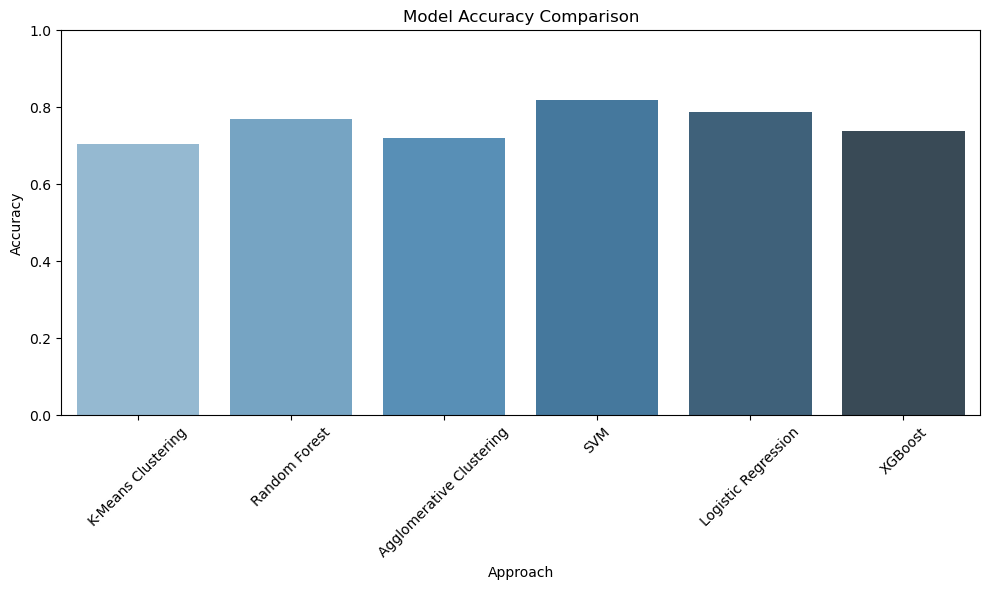

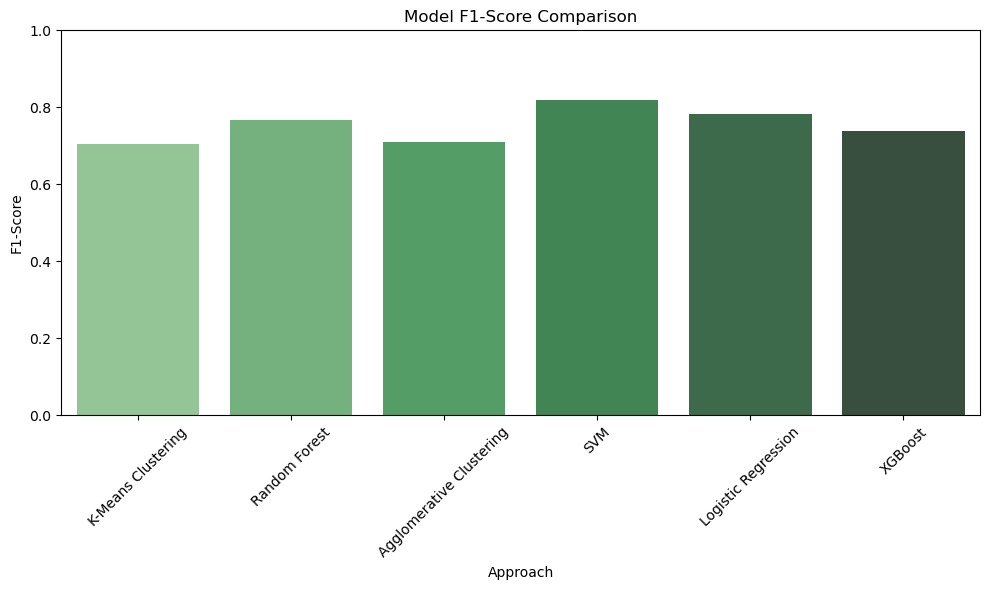

In [76]:
# Visualization for Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Approach', y='Accuracy', data=summary, palette='Blues_d')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Visualization for F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Approach', y='F1-Score', data=summary, palette='Greens_d')
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [92]:
#model imrpovement RF using gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train)

# Print the best parameters and best score
print("Best Parameters for Random Forest:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.8470531400966184


In [78]:
from sklearn.pipeline import Pipeline

# Standardize features and perform hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000))
])

param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__solver': ['liblinear', 'saga']  # solvers that support L1
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

print("Best Parameters for Logistic Regression:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters for Logistic Regression: {'log_reg__C': 0.01, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}
Best Accuracy: 0.8166183574879227


In [79]:
# Standardize features and perform hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

print("Best Parameters for SVM:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters for SVM: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Accuracy: 0.8384541062801931


In [88]:
from sklearn.metrics import silhouette_score
import os
os.environ['OMP_NUM_THREADS'] = '1'

# Standardize features and determine the optimal number of clusters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_pca)

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score}")

optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_k)

Silhouette Score for k=2: 0.08547430207438639
Silhouette Score for k=3: 0.09769858264810483
Silhouette Score for k=4: 0.09500879029380245
Silhouette Score for k=5: 0.10029332799557908
Silhouette Score for k=6: 0.0887900648164862
Silhouette Score for k=7: 0.08350051331018
Silhouette Score for k=8: 0.06884340160060436
Silhouette Score for k=9: 0.08668186073612147
Silhouette Score for k=10: 0.0866264559131927
Optimal number of clusters: 5


C:\Users\anmar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\anmar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\anmar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\anmar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Window

In [89]:
# K-Means Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_pca)

# Get cluster labels for the training data
train_clusters = kmeans.labels_

# Map each cluster to the majority class in the training data
cluster_labels = {}
for cluster_id in np.unique(train_clusters):
    # Select rows belonging to this cluster
    cluster_points = y_train[train_clusters == cluster_id]
    # Find the majority class in this cluster
    majority_class = cluster_points.value_counts().idxmax()
    cluster_labels[cluster_id] = majority_class

print("Cluster to class mapping (based on training majority):", cluster_labels)

# Assign clusters to test data
test_clusters = kmeans.predict(X_test_pca)

# Map cluster assignments to predicted classes
y_pred_cluster = [cluster_labels[c] for c in test_clusters]

# Evaluate the clustering approach
print("Clustering Approach (KMeans):")
print("Accuracy:", accuracy_score(y_test, y_pred_cluster))
print("Classification Report:\n", classification_report(y_test, y_pred_cluster))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cluster))

Cluster to class mapping (based on training majority): {0: 1, 1: 0, 2: 1, 3: 1, 4: 0}
Clustering Approach (KMeans):
Accuracy: 0.7049180327868853
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.57      0.64        28
           1       0.69      0.82      0.75        33

    accuracy                           0.70        61
   macro avg       0.71      0.69      0.70        61
weighted avg       0.71      0.70      0.70        61

Confusion Matrix:
 [[16 12]
 [ 6 27]]


C:\Users\anmar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_pca)

best_silhouette_score = -1
best_linkage = None
best_n_clusters = None
best_cluster_labels = None

# Try different linkage criteria and number of clusters
for linkage in ['ward', 'complete', 'average', 'single']:
    for n_clusters in range(2, 6):
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = agg_clustering.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        print(f"Linkage: {linkage}, Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")

        # Update the best configuration if the current one is better
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_linkage = linkage
            best_n_clusters = n_clusters
            best_cluster_labels = cluster_labels

# Assuming y_train is the true labels for the training data
# Map cluster labels to true labels (this is a heuristic approach)
# This step is necessary because cluster labels are arbitrary
from scipy.stats import mode

# Create a mapping from cluster labels to true labels
label_mapping = np.zeros_like(best_cluster_labels)
for cluster in range(best_n_clusters):
    mask = (best_cluster_labels == cluster)
    label_mapping[mask] = mode(y_train[mask])[0]

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_train, label_mapping)
conf_matrix = confusion_matrix(y_train, label_mapping)

print(f"\nBest Linkage: {best_linkage}, Best Clusters: {best_n_clusters}, Best Silhouette Score: {best_silhouette_score:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print("Confusion Matrix:\n", conf_matrix)

Linkage: ward, Clusters: 2, Silhouette Score: 0.128
Linkage: ward, Clusters: 3, Silhouette Score: 0.082
Linkage: ward, Clusters: 4, Silhouette Score: 0.050
Linkage: ward, Clusters: 5, Silhouette Score: 0.065
Linkage: complete, Clusters: 2, Silhouette Score: 0.128
Linkage: complete, Clusters: 3, Silhouette Score: 0.124
Linkage: complete, Clusters: 4, Silhouette Score: 0.125
Linkage: complete, Clusters: 5, Silhouette Score: 0.053
Linkage: average, Clusters: 2, Silhouette Score: 0.228
Linkage: average, Clusters: 3, Silhouette Score: 0.182
Linkage: average, Clusters: 4, Silhouette Score: 0.113
Linkage: average, Clusters: 5, Silhouette Score: 0.093
Linkage: single, Clusters: 2, Silhouette Score: 0.184
Linkage: single, Clusters: 3, Silhouette Score: 0.161
Linkage: single, Clusters: 4, Silhouette Score: 0.154
Linkage: single, Clusters: 5, Silhouette Score: 0.095

Best Linkage: average, Best Clusters: 2, Best Silhouette Score: 0.228
Accuracy: 0.568
Confusion Matrix:
 [[  3  99]
 [  0 127]]


C:\Users\anmar\AppData\Local\Temp\ipykernel_25928\3565675019.py:33: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label_mapping[mask] = mode(y_train[mask])[0]


In [97]:
# Define the results for each model
results = {
    "Random Forest": {
        "Best Parameters": {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
        "Best Accuracy": 0.8470531400966184
    },
    "Logistic Regression": {
        "Best Parameters": {'log_reg__C': 0.01, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'},
        "Best Accuracy": 0.8166183574879227
    },
    "SVM": {
        "Best Parameters": {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'},
        "Best Accuracy": 0.8384541062801931
    },
    "KMeans Clustering": {
        "Cluster to Class Mapping": {0: 1, 1: 0, 2: 1, 3: 1, 4: 0},
        "Accuracy": 0.7049180327868853
    },
    "Agglomerative Clustering": {
        "Best Linkage": "average",
        "Best Clusters": 2,
        "Best Silhouette Score": 0.228,
        "Accuracy": 0.568
    }
}

# Print the results
for model, metrics in results.items():
    print(f"\n{model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Random Forest
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.8470531400966184

Logistic Regression
Best Parameters: {'log_reg__C': 0.01, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}
Best Accuracy: 0.8166183574879227

SVM
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Accuracy: 0.8384541062801931

KMeans Clustering
Cluster to Class Mapping: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0}
Accuracy: 0.7049180327868853

Agglomerative Clustering
Best Linkage: average
Best Clusters: 2
Best Silhouette Score: 0.228
Accuracy: 0.568


In [99]:
model_results = {
    "Random Forest": 0.8470531400966184,
    "Logistic Regression": 0.8166183574879227,
    "SVM": 0.8384541062801931,
    "KMeans Clustering": 0.7049180327868853,
    "Agglomerative Clustering": 0.568
}

# Find the model with the highest accuracy
best_model = max(model_results, key=model_results.get)
best_accuracy = model_results[best_model]

print(f"The best model is {best_model} with an accuracy of {best_accuracy:.4f}.")

The best model is Random Forest with an accuracy of 0.8471.


In [109]:
df_binary = df.copy()
for col in df_binary.columns:
    # Binarize based on whether value is above mean or not
    threshold = df_binary[col].mean()
    df_binary[col] = df_binary[col].apply(lambda x: 1 if x > threshold else 0)

# Now df_binary is a dataset with 1/0 indicating "presence" of that feature condition
frequent_itemsets = apriori(df_binary, min_support=0.3, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.7, num_itemsets=2)
print("Frequent Itemsets:")
print(frequent_itemsets.head())

print("\nAssociation Rules:")
print(rules.head())

Frequent Itemsets:
    support    itemsets
0  0.524752       (age)
1  0.683168       (sex)
2  0.528053        (cp)
3  0.435644  (trestbps)
4  0.448845      (chol)

Association Rules:
  antecedents consequents  antecedent support  consequent support   support  \
0        (ca)       (sex)            0.422442            0.683168  0.316832   
1      (thal)       (sex)            0.386139            0.683168  0.336634   
2        (cp)   (thalach)            0.528053            0.564356  0.389439   
3    (target)        (cp)            0.544554            0.528053  0.415842   
4        (cp)    (target)            0.528053            0.544554  0.415842   

   confidence      lift  representativity  leverage  conviction  \
0    0.750000  1.097826               1.0  0.028233    1.267327   
1    0.871795  1.276106               1.0  0.072836    2.471287   
2    0.737500  1.306798               1.0  0.091429    1.659595   
3    0.763636  1.446136               1.0  0.128288    1.996700   
4    0.

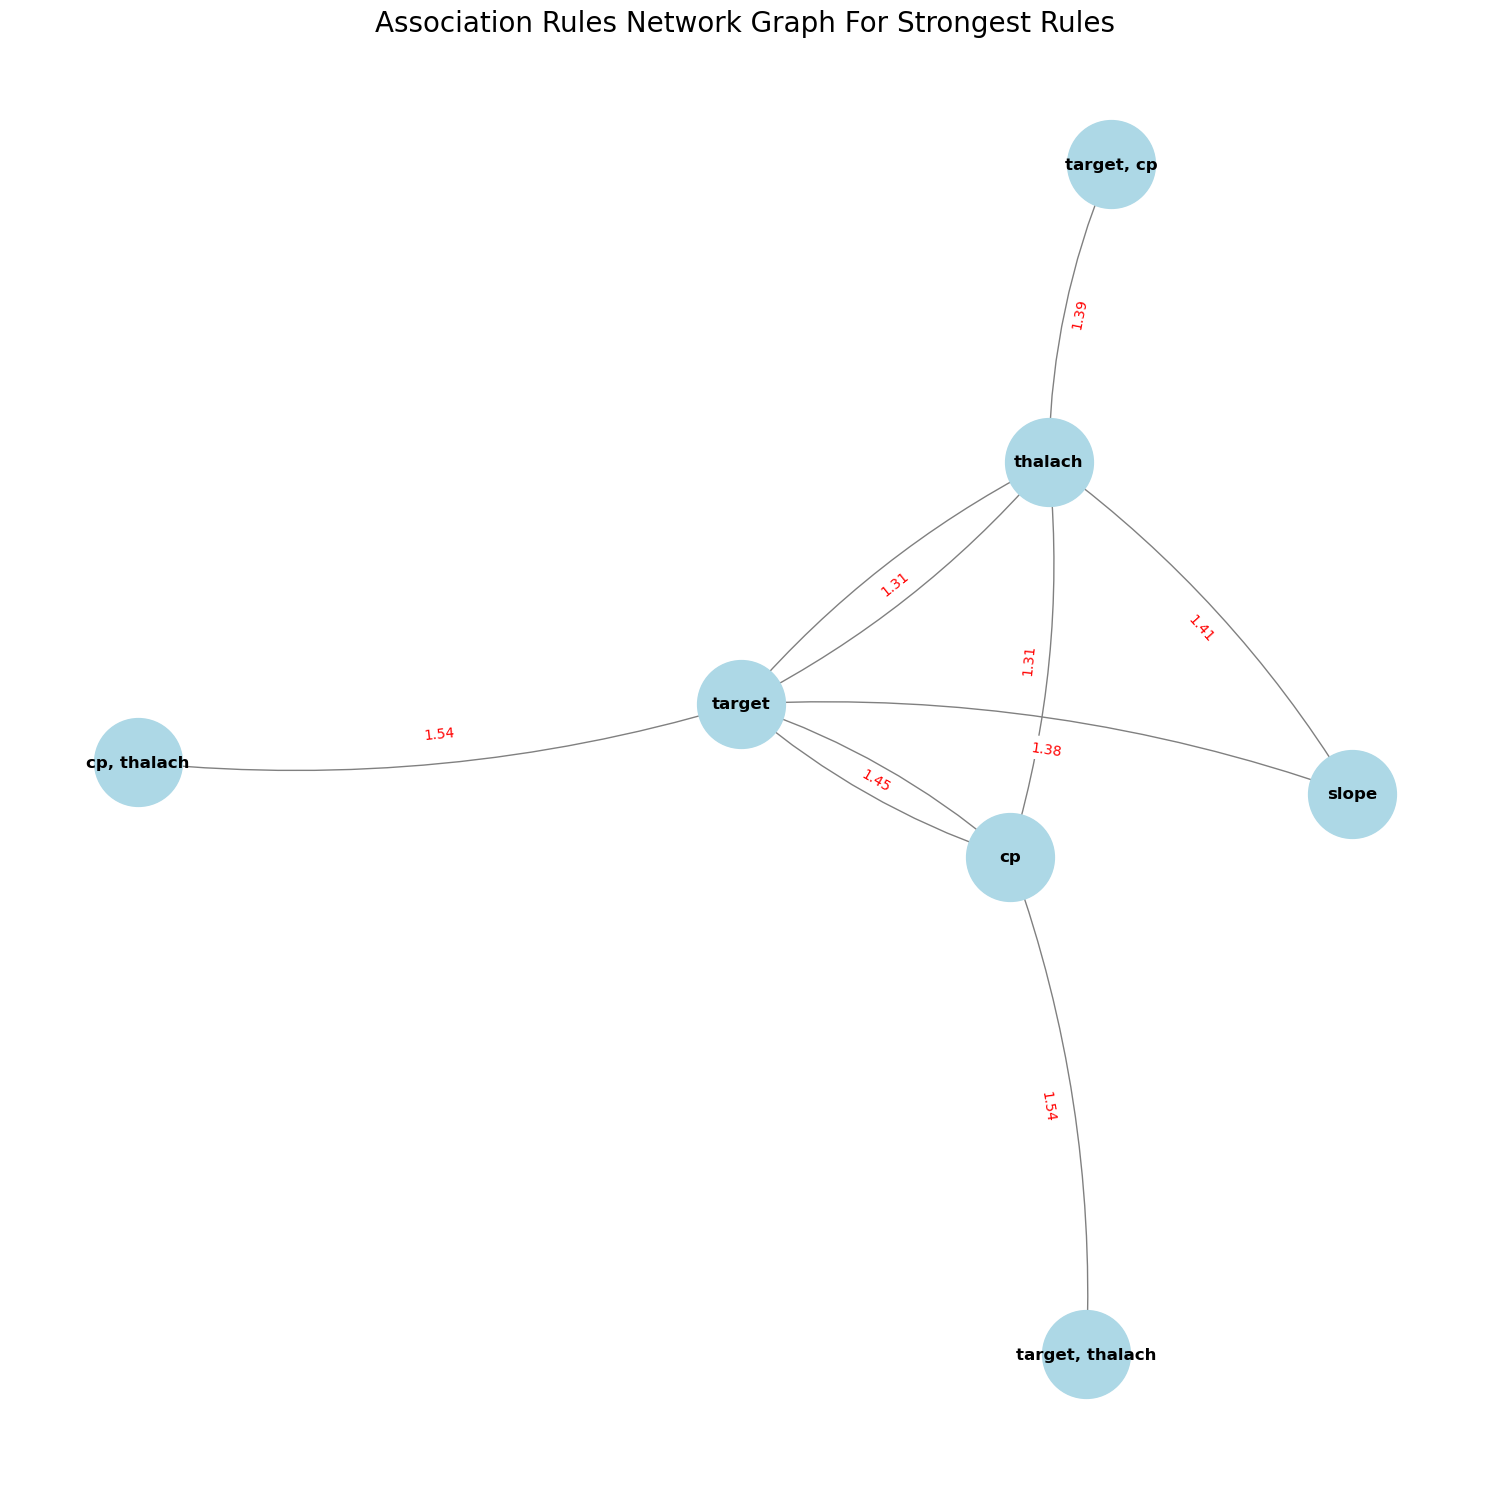

In [112]:
import networkx as nx

# Filter rules with lift greater than 1
strong_rules = rules[rules['lift'] > 1]
strong_rules = strong_rules.sort_values(by='lift', ascending=False)
strong_rules.reset_index(drop=True, inplace=True)

# Visualize Rules
GRAPH_RULES = strong_rules.head(10).copy()

# Make all antecedents and consequents as string
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(lambda x: ', '.join(list(x)))
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(lambda x: ', '.join(list(x)))

def insert_newline(x):
    if '_' in x:
        parts = x.rsplit('_', 1)
        return parts[0] + '\n' + parts[1]
    else:
        return x

# Apply the function to antecedents and consequents
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(insert_newline)
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(insert_newline)

G = nx.from_pandas_edgelist(
    df=GRAPH_RULES,
    source='antecedents',
    target='consequents',
    edge_attr=True,
    create_using=nx.DiGraph
)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.5, seed=1) 

nx.draw_networkx_nodes(G, pos, node_size=4000, node_color='lightblue')

nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle='-|>',
    arrowsize=20,
    edge_color='gray',
    connectionstyle='arc3,rad=0.1'
)

nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

edge_labels = {(u, v): f"{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Association Rules Network Graph For Strongest Rules', size=20)
plt.axis('off')
plt.tight_layout()
plt.show()